# Deep backward schemes for high-dimensional nonlinear PDEs

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("..")

from dbdp.solvers import DBDP1Solver
from dbdp.models import build_path

## Example 1 :

$$
    \mu=0.2,\ \sigma=1,\ T=2,\ x_0=1
$$

$$
    g(x)=\cos(x)
$$

$$
    f(t,x,y,z)=(\cos(x)(e^{\frac{T-t}{2}}+\sigma^2/2)+\mu\sin(x))e^{\frac{T-t}{2}}-\frac{1}{2}(\sin(x)\cos(x)e^{T-t})^2+\frac{1}{2}(yz)^2
$$

In [2]:
class Example1SDE:
    def __init__(self, mu: float, sigma: float):
        self._mu = torch.tensor(mu)
        self._sigma = torch.tensor(sigma)

    def drift(self, t, x) -> torch.Tensor:
        return self._mu

    def diffusion(self, t, x) -> torch.Tensor:
        return self._sigma

    @property
    def dim(self) -> int:
        return 1


mu = 0.2
sigma = 1.0

sde = Example1SDE(mu, sigma)

maturity = 2.0
time_steps = 240
dt = maturity / time_steps

sample_count = 10_000

x0 = torch.Tensor([1.0])
dim = x0.dim()


def f(t, x, y, z):
    a = torch.cos(x) * (np.exp((maturity - t) / 2) + sigma**2 / 2) + mu * torch.sin(x)
    b = -((torch.sin(x) * torch.cos(x) * np.exp(maturity - t)) ** 2) + (y * z) ** 2
    return a * np.exp((maturity - t) / 2) + b / 2


def g(x):
    return torch.cos(x)


def true_u(t, x):
    return np.exp((maturity - t) / 2) * torch.cos(x)

In [ ]:
dbdp1 = DBDP1Solver(f, g, maturity, time_steps, dim)
# dbdp1.load("../models/example-01.pt")

In [4]:
# Generating datas
dw = np.sqrt(dt) * torch.randn((sample_count, time_steps, dim))
x_paths = build_path(sde, x0, dt, dw)

print("Shapes:")
print(f"- dw: {dw.shape}")
print(f"-  x: {x_paths.shape}")

Shapes:
- dw: torch.Size([10000, 240, 1])
-  x: torch.Size([10000, 241, 1])


In [5]:
trains_losses, tests_losses = dbdp1.train(
    x_paths,
    dw,
    num_epochs=400,
    batch_size=1_000,
    lr=1e-2,
)
# dbdp1.save("../models/example-01.pt")

Training: 100%|██████████| 240/240 [1:20:43<00:00, 20.18s/it]


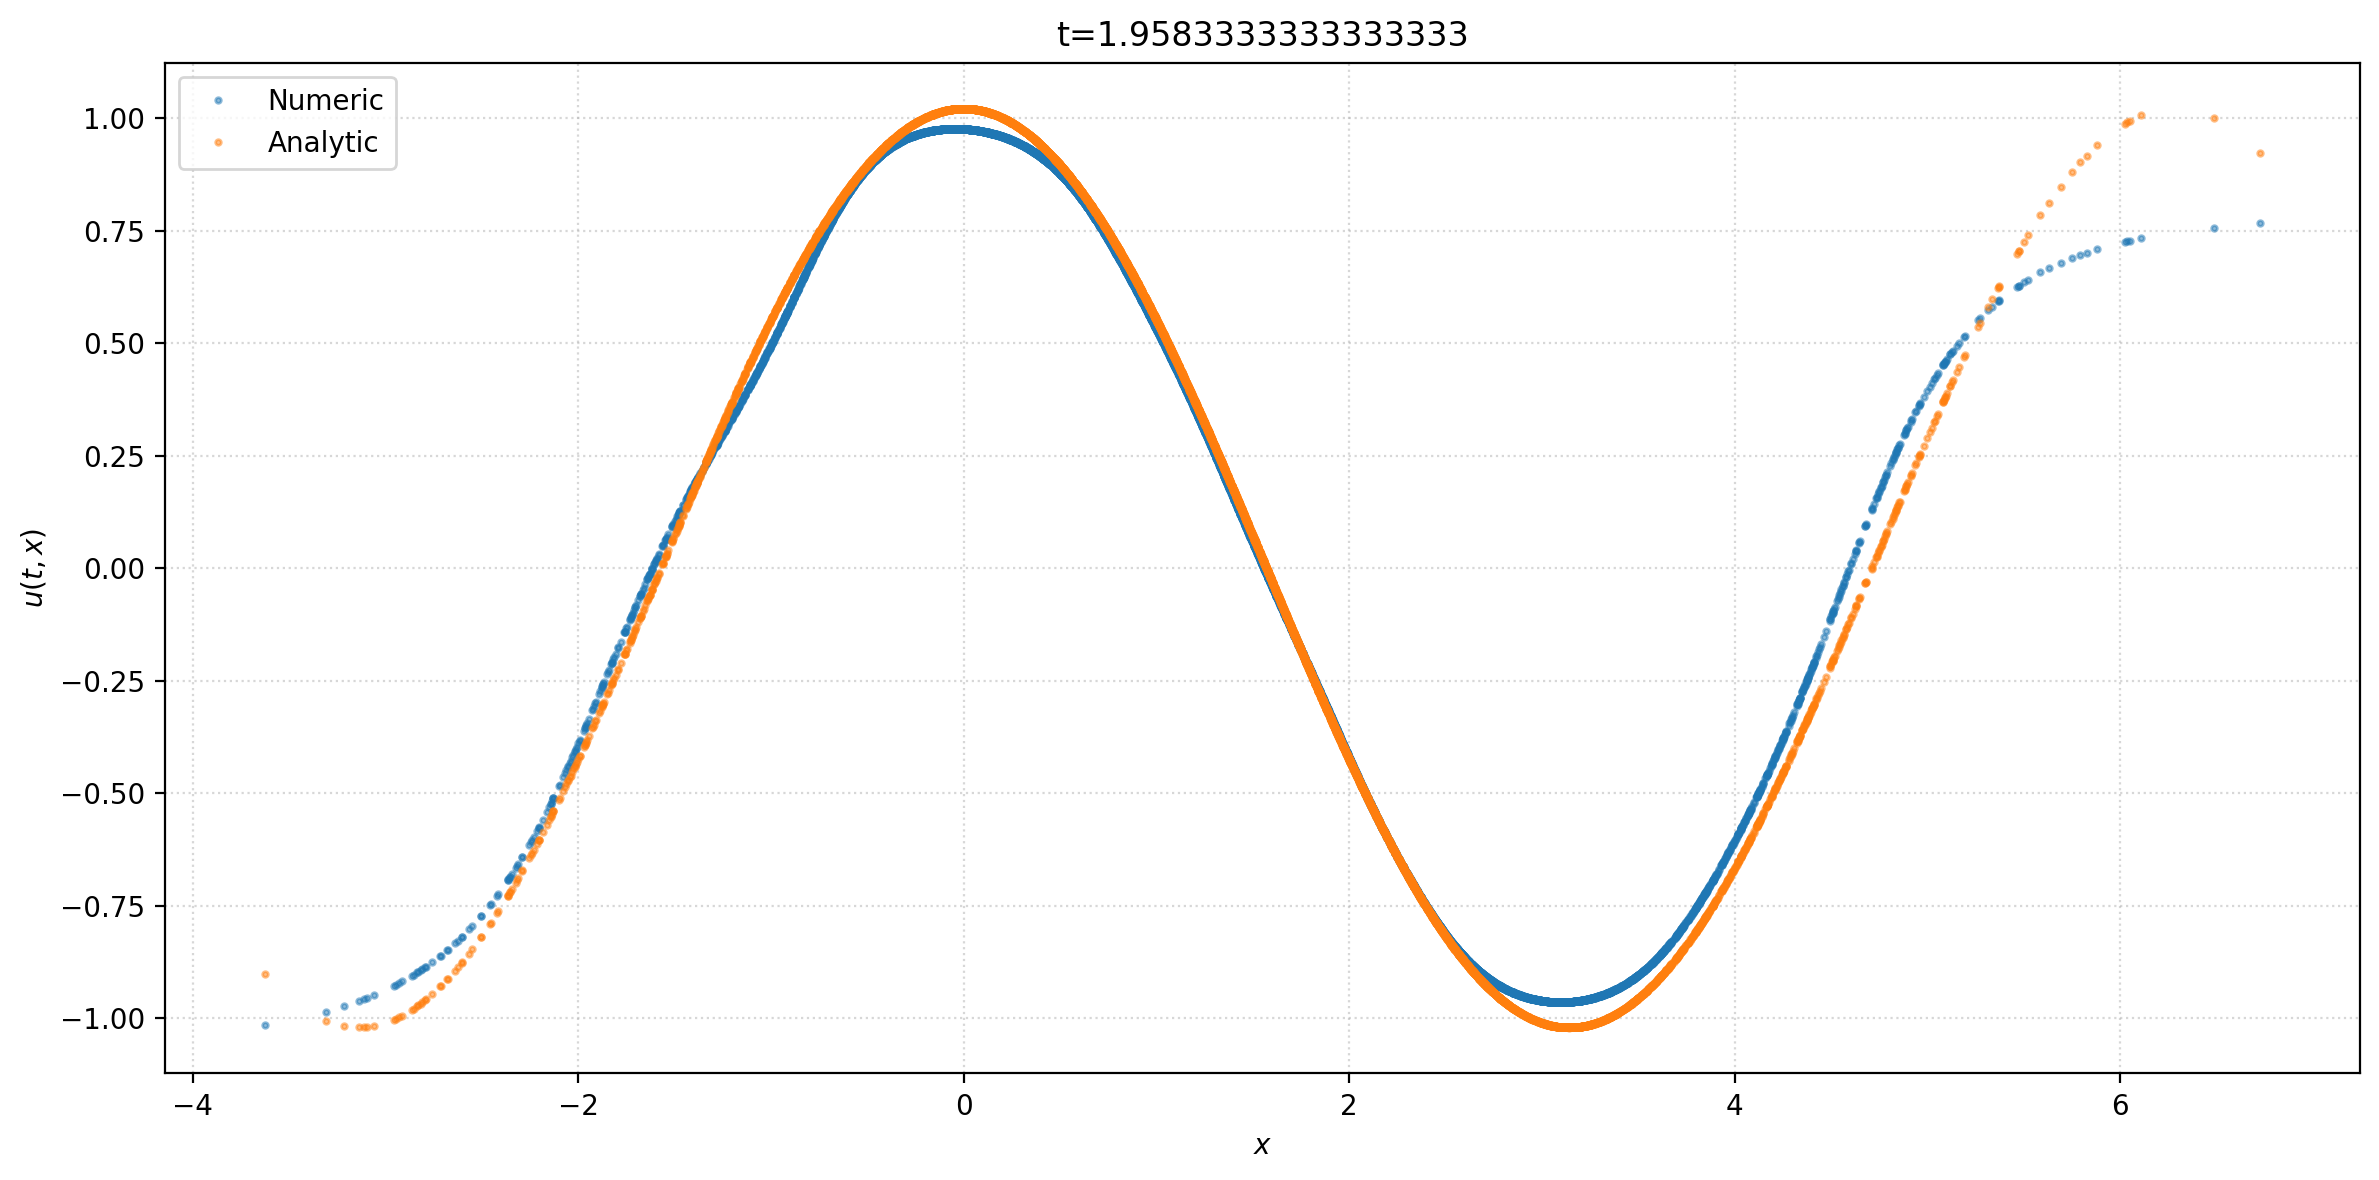

In [13]:
u_approx = dbdp1

time = np.linspace(0, maturity, time_steps + 1)
t = time[235]
xs = x_paths[:, 235].unsqueeze(1)[:, :, 0]
ys = u_approx(t, xs).detach()

plt.figure(figsize=(12, 6), dpi=200)
plt.title(f"t={t}")
plt.plot(xs, ys, ".", markersize=4, label="Numeric", alpha=0.5)
plt.plot(xs, true_u(t, xs), ".", markersize=4, label="Analytic", alpha=0.5)
plt.grid(alpha=0.5, ls="dotted")
plt.xlabel("$x$")
plt.ylabel("$u(t,x)$")
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

In [7]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(12, 6), dpi=200)
    plt.title("Evolution of training and test error")
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.loglog()
    plt.grid(alpha=0.5, ls="dotted")
    plt.tight_layout()
    plt.legend()

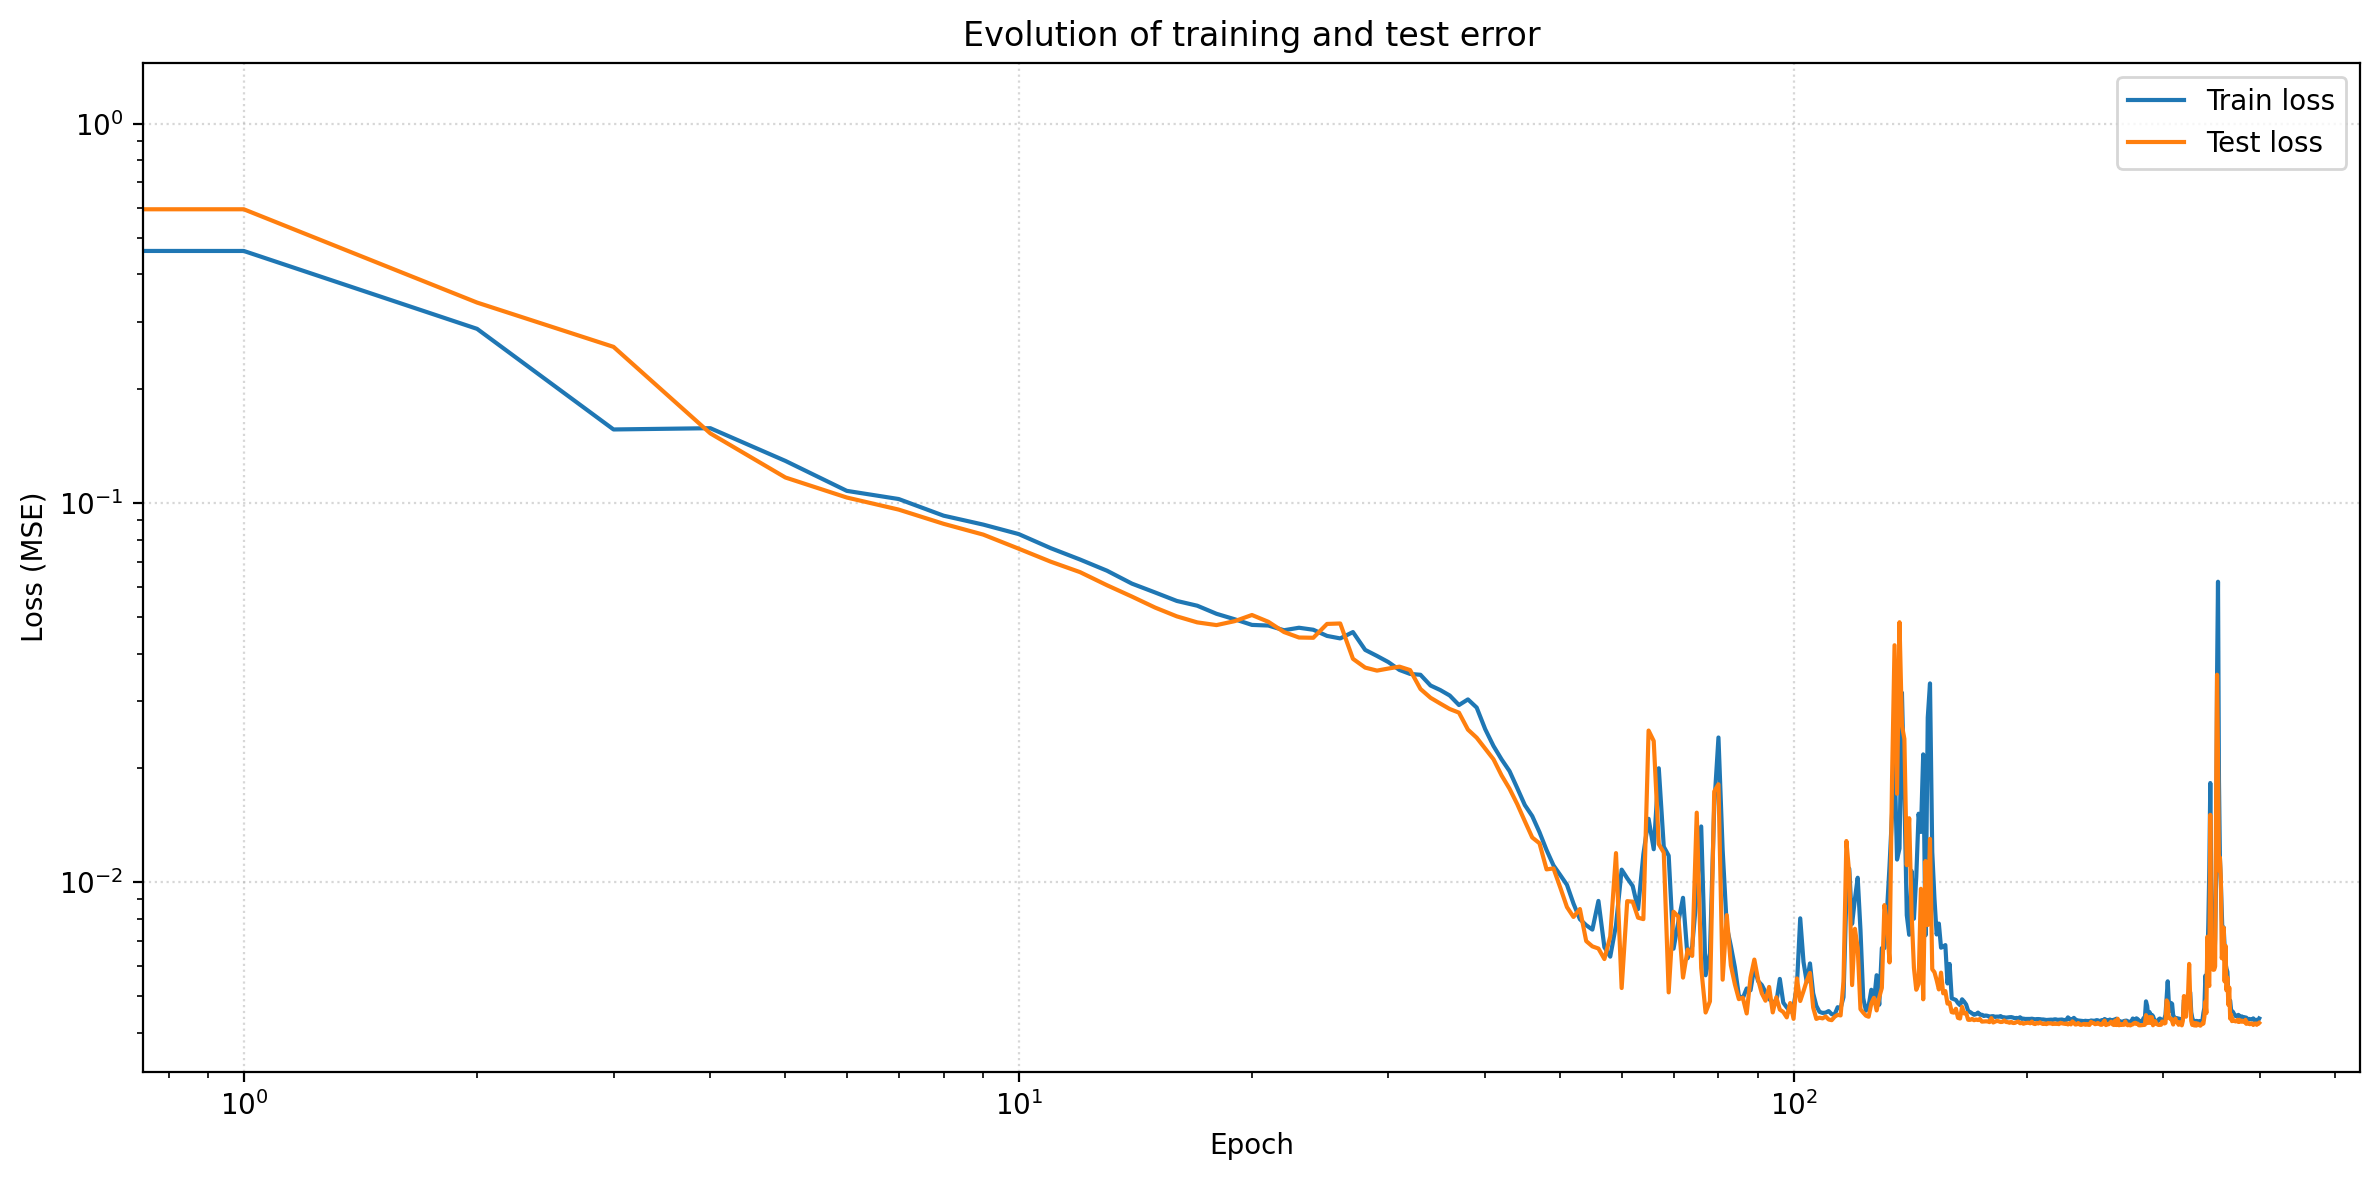

In [16]:
plot_losses(trains_losses[0], tests_losses[0])